Below is an implementation of variational autoencoders, training on MNIST. This notebook is heavily adapted from 
https://tiao.io/post/tutorial-on-variational-autoencoders-with-a-concise-keras-implementation/ and https://wiseodd.github.io/techblog/2016/12/10/variational-autoencoder/

In [1]:
import warnings
import numpy as np
from keras.layers import Input, Dense, Lambda
from keras.layers.merge import concatenate as concat
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
#from scipy.misc import imsave
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
%pylab inline

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


Load and preprocess the data.

In [2]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

n_pixels = np.prod(X_train.shape[1:])
X_train = X_train.reshape((len(X_train), n_pixels))
X_test = X_test.reshape((len(X_test), n_pixels))
print("n_pixels: " + str(n_pixels))

n_pixels: 784


One-hot encode the MNIST number labels.

In [3]:
y_train = to_categorical(Y_train)
y_test = to_categorical(Y_test)

Set hyperparameters for training.

In [4]:
m = 250 # batch size
n_z = 2 # latent space size
encoder_dim1 = 512 # dim of encoder hidden layer
decoder_dim = 512 # dim of decoder hidden layer
decoder_out_dim = 784 # dim of decoder output layer
activ = 'relu'
optim = Adam(lr=0.001)


n_x = X_train.shape[1]
n_y = y_train.shape[1]


n_epoch = 25

Instructions for updating:
Colocations handled automatically by placer.


# Variational Autoencoders

First, we specify the encoder architecture, which will be a one hidden layer neural network (with 512 neurons)

In [5]:
X = Input(shape=(n_x,))
encoder_h = Dense(encoder_dim1, activation=activ)(X)
mu = Dense(n_z, activation='linear')(encoder_h)
l_sigma = Dense(n_z, activation='linear')(encoder_h)

We implement the reparametrization trick as a special keras Lambda layer.

In [33]:
# reparametrization trick
def sample_z(args):
    mu, l_sigma = args
    eps = K.random_normal(shape=(m, n_z), mean=0., stddev=1.)
    return mu + K.exp(l_sigma / 2) * eps

# Sampling latent space
z = Lambda(sample_z, output_shape = (n_z, ))([mu, l_sigma])

250


We next specify the decoder, which is also a one-layer hidden neural network.

In [7]:
decoder_hidden = Dense(512, activation='relu')
decoder_out = Dense(784, activation='sigmoid')

h_p = decoder_hidden(z)
outputs = decoder_out(h_p)

In variational autoencoders, we are optimizing the variational objective (also called ELBO). We specify this in Keras:

In [8]:
def vae_loss(y_true, y_pred):
    # E[]
    recon = K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)
    # closed from KL divergence between two gaussians
    kl = 0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=-1)
    return recon + kl

We set up the model, encoder, and decoder, then compile and train.

In [9]:
# Overall VAE Model
vae = Model([X], outputs)

# Set encoder model
encoder = Model([X], mu)

# Set decoder model
d_in = Input(shape=(n_z,))
d_h = decoder_hidden(d_in)
d_out = decoder_out(d_h)
decoder = Model(d_in, d_out)   

In [10]:
vae.compile(optimizer=optim, loss=vae_loss)

vae_hist = vae.fit([X_train], X_train, verbose = 1, batch_size=m, epochs=n_epoch,
                     validation_data = ([X_test], X_test),
                     callbacks = [EarlyStopping(patience = 5)])

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/25
60000/60000 [==============================] - 8s 137us/step - loss: 212.4778 - val_loss: 181.5907
Epoch 2/25
60000/60000 [==============================] - 8s 127us/step - loss: 176.1722 - val_loss: 170.8480
Epoch 3/25
60000/60000 [==============================] - 8s 129us/step - loss: 168.7633 - val_loss: 166.7902
Epoch 4/25
60000/60000 [==============================] - 8s 128us/step - loss: 165.8554 - val_loss: 164.8521
Epoch 5/25
60000/60000 [==============================] - 8s 129us/step - loss: 164.0024 - val_loss: 163.4009
Epoch 6/25
60000/60000 [==============================] - 8s 133us/step - loss: 162.6114 - val_loss: 162.1880
Epoch 7/25
60000/60000 [==============================] - 8s 128us/step - loss: 161.4696 - val_loss: 161.2867
Epoch 8/25
60000/60000 [==============================] - 8s 127us/step - loss: 160.4998 - val_loss: 160.3219
Epoch 9/25
60000/60000

We test the output of the decoder on some settings of the latent variables.

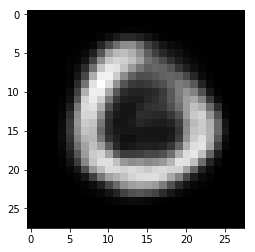

In [42]:
latents = np.random.normal(size=2)
latents = [0, 2]
x_decoded = decoder.predict(np.array(latents).reshape(1, 2))
x_decoded = x_decoded.reshape(28, 28)
plt.imshow(x_decoded, cmap=plt.cm.gray)

### Conditional Variational Autoencoders

In the CVAE training, we add the one-hot encoded label of the training image to the input to the network. Everything else is exactly the same.

In [12]:
X = Input(shape=(n_x,))
label = Input(shape=(n_y,))
# Concatenate
inputs = concat([X, label])

In [13]:
encoder_h = Dense(encoder_dim1, activation=activ)(inputs)
mu = Dense(n_z, activation='linear')(encoder_h)
l_sigma = Dense(n_z, activation='linear')(encoder_h)

In [17]:
# reparametrization trick
def sample_z(args):
    mu, l_sigma = args
    eps = K.random_normal(shape=(m, n_z), mean=0., stddev=1.)
    return mu + K.exp(l_sigma / 2) * eps


# Sampling latent space
z = Lambda(sample_z, output_shape = (n_z, ))([mu, l_sigma])

We have to add the label to the decoder input as well.

In [18]:
z = Lambda(sample_z, output_shape = (n_z, ))([mu, l_sigma])

# merge latent space with label
zc = concat([z, label])


decoder_hidden = Dense(decoder_dim, activation=activ)
decoder_out = Dense(decoder_out_dim, activation='sigmoid')
h_p = decoder_hidden(zc)
outputs = decoder_out(h_p)

In [19]:
cvae = Model([X, label], outputs)
cvae_encoder = Model([X, label], mu)

d_in = Input(shape=(n_z+n_y,))
d_h = decoder_hidden(d_in)
d_out = decoder_out(d_h)
cvae_decoder = Model(d_in, d_out)

Finally, compile and train.

In [20]:
cvae.compile(optimizer=optim, loss=vae_loss)

cvae_hist = cvae.fit([X_train, y_train], X_train, verbose = 1, batch_size=m, epochs=n_epoch,
                     validation_data = ([X_test, y_test], X_test),
                     callbacks = [EarlyStopping(patience = 5)])

Train on 60000 samples, validate on 10000 samples
Epoch 1/25
60000/60000 [==============================] - 8s 138us/step - loss: 161.2080 - val_loss: 142.3902
Epoch 2/25
60000/60000 [==============================] - 8s 131us/step - loss: 140.7462 - val_loss: 139.1391
Epoch 3/25
60000/60000 [==============================] - 8s 130us/step - loss: 138.3949 - val_loss: 137.6539
Epoch 4/25
60000/60000 [==============================] - 8s 131us/step - loss: 137.0234 - val_loss: 136.5416
Epoch 5/25
60000/60000 [==============================] - 8s 132us/step - loss: 136.1507 - val_loss: 135.6963
Epoch 6/25
60000/60000 [==============================] - 8s 131us/step - loss: 135.4750 - val_loss: 135.3262
Epoch 7/25
60000/60000 [==============================] - 8s 131us/step - loss: 134.9531 - val_loss: 134.9398
Epoch 8/25
60000/60000 [==============================] - 8s 130us/step - loss: 134.5000 - val_loss: 134.4973
Epoch 9/25
60000/60000 [==============================] - 8s 130us/ste

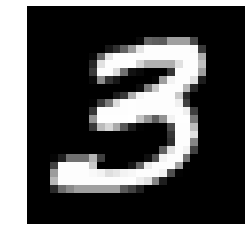

In [21]:
plt.imshow(X_train[909].reshape(28, 28), cmap = plt.cm.gray), axis('off')
plt.show()

We can feed this image into the encoder to see what latent variable settings it has.

In [22]:
encoded_X0 = cvae_encoder.predict([X_train[909].reshape((1, 784)), y_train[0].reshape((1, 10))])
print(encoded_X0)

[[ 0.98373777 -0.04653868]]


In [23]:
def construct_numvec(digit, z = [-1, -1]):
    out = np.zeros((1, n_z + n_y))
    out[:, digit + n_z] = .5
    out[:, digit + n_z -1] = .5
    if z is None:
        return(out)
    else:
        for i in range(len(z)):
            out[:,i] = z[i]
        return(out)

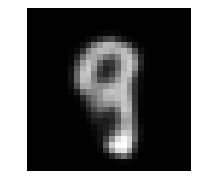

In [24]:
digit=9
plt.figure(figsize=(3, 3))
plt.imshow(cvae_decoder.predict(construct_numvec(digit)).reshape(28,28), cmap = plt.cm.gray), axis('off')
plt.show()

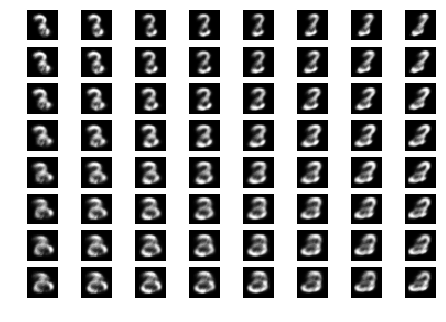

In [25]:
dig = 3
sides = 8
max_z = 1.5

img_it = 0
for i in range(0, sides):
    z1 = (((i / (sides-1)) * max_z)*2) - max_z
    for j in range(0, sides):
        z2 = (((j / (sides-1)) * max_z)*2) - max_z
        z_ = [z1, z2]
        vec = construct_numvec(dig, z_)
        decoded = cvae_decoder.predict(vec)
        subplot(sides, sides, 1 + img_it)
        img_it +=1
        plt.imshow(decoded.reshape(28, 28), cmap = plt.cm.gray), axis('off')
        
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=.2)
plt.show()